In [ ]:
# AutoRoot – AI System Failure Root Cause Analyzer

# AutoRoot is an AI-driven system designed to analyze system telemetry at scale,
# detect operational anomalies, and perform automated root cause analysis
# across metrics and logs.

# The system follows standard SRE and DevOps design principles, combining
# statistical anomaly detection, rule-based correlation, and explainable
# machine learning to assist incident diagnosis in distributed environments.

# This project focuses on building a modular, production-style pipeline
# covering data generation, feature engineering, anomaly detection,
# root cause inference, and interpretability, exposed through APIs
# and a lightweight monitoring dashboard.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil

source_path = "synthetic_system_data.csv"
target_path = "/content/drive/MyDrive/AutoRoot/synthetic_system_data.csv"

# Create folder if it doesn't exist
import os
os.makedirs("/content/drive/MyDrive/AutoRoot", exist_ok=True)

shutil.copy(source_path, target_path)

print("Dataset saved to Google Drive at:", target_path)


Dataset saved to Google Drive at: /content/drive/MyDrive/AutoRoot/synthetic_system_data.csv


In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn shap fastapi uvicorn pyngrok streamlit


In [ ]:
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

import shap


In [ ]:
def generate_synthetic_system_data(
    rows=5000,
    anomaly_ratio=0.05
):
    start_time = datetime.now()
    data = []

    for i in range(rows):
        timestamp = start_time + timedelta(seconds=i*10)

        cpu = np.random.normal(40, 5)
        memory = np.random.normal(60, 6)
        latency = np.random.normal(120, 15)
        error_rate = max(0, np.random.normal(0.5, 0.2))

        log_level = "INFO"
        message = "Service running normally"

        # Inject anomalies
        if random.random() < anomaly_ratio:
            anomaly_type = random.choice(["CPU", "MEMORY", "NETWORK"])

            if anomaly_type == "CPU":
                cpu += random.uniform(40, 60)
                latency += random.uniform(200, 400)
                error_rate += random.uniform(2, 5)
                log_level = "ERROR"
                message = "CPU saturation detected"

            elif anomaly_type == "MEMORY":
                memory += random.uniform(30, 50)
                error_rate += random.uniform(1, 3)
                log_level = "CRITICAL"
                message = "Memory leak suspected"

            elif anomaly_type == "NETWORK":
                latency += random.uniform(300, 600)
                error_rate += random.uniform(2, 4)
                log_level = "WARN"
                message = "Network congestion detected"

        data.append([
            timestamp, cpu, memory, latency, error_rate, log_level, message
        ])

    df = pd.DataFrame(
        data,
        columns=[
            "timestamp", "cpu", "memory", "latency",
            "error_rate", "log_level", "message"
        ]
    )
    return df


In [ ]:
df = generate_synthetic_system_data()
df.head()


,timestamp,cpu,memory,latency,error_rate,log_level,message
0,2025-12-19 11:35:22.221437,42.273787,63.750172,122.488487,0.517258,INFO,Service running normally
1,2025-12-19 11:35:32.221437,41.658362,49.579010,103.060052,0.529331,INFO,Service running normally
2,2025-12-19 11:35:42.221437,55.103013,53.229343,124.582790,0.490502,INFO,Service running normally
3,2025-12-19 11:35:52.221437,32.741635,61.790346,125.307124,0.590245,INFO,Service running normally
4,2025-12-19 11:36:02.221437,53.123649,74.373180,113.336253,0.401660,INFO,Service running normally


In [ ]:
df.to_csv("synthetic_system_data.csv", index=False)
print("Dataset saved: synthetic_system_data.csv")


Dataset saved: synthetic_system_data.csv


In [ ]:
log_map = {
    "INFO": 0,
    "WARN": 1,
    "ERROR": 2,
    "CRITICAL": 3
}

df["log_severity"] = df["log_level"].map(log_map)


In [ ]:
df["cpu_delta"] = df["cpu"].diff().fillna(0)
df["memory_delta"] = df["memory"].diff().fillna(0)
df["latency_delta"] = df["latency"].diff().fillna(0)

df["cpu_rolling_mean"] = df["cpu"].rolling(10).mean().fillna(df["cpu"])
df["latency_rolling_mean"] = df["latency"].rolling(10).mean().fillna(df["latency"])


In [ ]:
features = df[
    [
        "cpu", "memory", "latency", "error_rate",
        "log_severity",
        "cpu_delta", "memory_delta", "latency_delta",
        "cpu_rolling_mean", "latency_rolling_mean"
    ]
]


In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(features)


In [ ]:
anomaly_model = IsolationForest(
    n_estimators=200,
    contamination=0.05,
    random_state=42
)

df["anomaly"] = anomaly_model.fit_predict(X)
df["anomaly"] = df["anomaly"].map({1: 0, -1: 1})

df["anomaly"].value_counts()


,count
anomaly,
0,4750
1,250


In [ ]:
def identify_root_cause(row):
    if row["cpu"] > 80 and row["latency"] > 300:
        return "CPU Saturation"
    elif row["memory"] > 85:
        return "Memory Leak"
    elif row["latency"] > 400:
        return "Network Congestion"
    elif row["error_rate"] > 3:
        return "Application Error Spike"
    else:
        return "Unknown"

df["root_cause"] = df.apply(identify_root_cause, axis=1)


In [ ]:
df[df["anomaly"] == 1][
    ["timestamp", "cpu", "memory", "latency", "error_rate", "root_cause"]
].head(10)


,timestamp,cpu,memory,latency,error_rate,root_cause
6,2025-12-19 11:36:22.221437,41.761175,100.550025,135.620091,2.743997,Memory Leak
52,2025-12-19 11:44:02.221437,44.033413,103.280335,87.563496,3.161509,Memory Leak
54,2025-12-19 11:44:22.221437,37.415546,90.309845,111.500991,1.706502,Memory Leak
72,2025-12-19 11:47:22.221437,87.273907,58.957735,432.099783,2.379396,CPU Saturation
84,2025-12-19 11:49:22.221437,90.519117,53.779381,518.992661,3.011439,CPU Saturation
99,2025-12-19 11:51:52.221437,45.597867,59.813928,656.780589,4.317621,Network Congestion
158,2025-12-19 12:01:42.221437,87.734830,49.992704,448.821470,4.469926,CPU Saturation
200,2025-12-19 12:08:42.221437,87.819540,60.444783,408.188597,2.875072,CPU Saturation
234,2025-12-19 12:14:22.221437,92.203992,55.749719,480.840657,4.169619,CPU Saturation
252,2025-12-19 12:17:22.221437,100.241161,62.913713,468.692807,3.647735,CPU Saturation


In [ ]:
explainer = shap.TreeExplainer(anomaly_model)
shap_values = explainer.shap_values(X[:500])


In [ ]:
explainer = shap.TreeExplainer(anomaly_model)
shap_values = explainer.shap_values(X[:500])


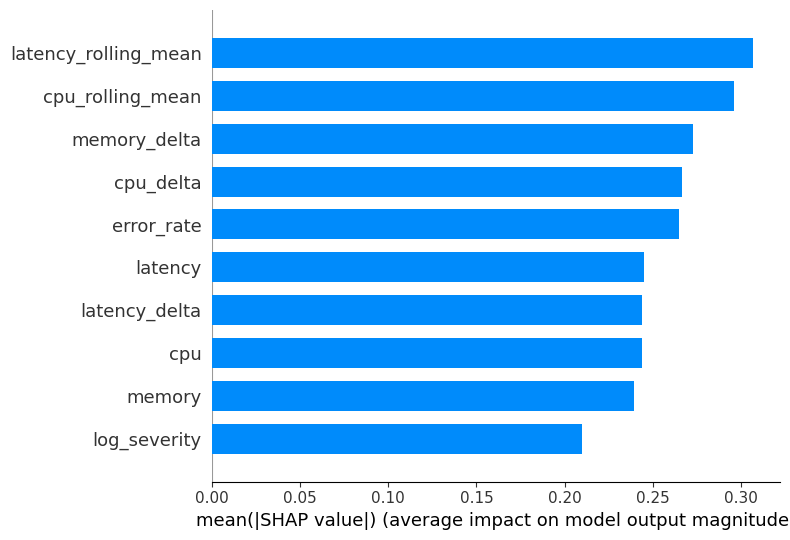

In [ ]:
shap.summary_plot(
    shap_values,
    features.iloc[:500],
    plot_type="bar"
)


In [ ]:
import joblib

joblib.dump(anomaly_model, "anomaly_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model artifacts saved")


Model artifacts saved


In [ ]:
import joblib

joblib.dump(anomaly_model, "anomaly_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model artifacts saved")


Model artifacts saved


In [ ]:
def analyze_event(input_data: dict):
    model = joblib.load("anomaly_model.pkl")
    scaler = joblib.load("scaler.pkl")

    input_df = pd.DataFrame([input_data])
    input_df["log_severity"] = input_df["log_severity"].astype(int)

    features = input_df[
        [
            "cpu", "memory", "latency", "error_rate",
            "log_severity",
            "cpu_delta", "memory_delta", "latency_delta",
            "cpu_rolling_mean", "latency_rolling_mean"
        ]
    ]

    X_scaled = scaler.transform(features)
    anomaly = model.predict(X_scaled)[0]
    anomaly = 0 if anomaly == 1 else 1

    root_cause = identify_root_cause(input_df.iloc[0])

    return {
        "anomaly": anomaly,
        "root_cause": root_cause
    }


In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel

app = FastAPI(
    title="AutoRoot API",
    description="AI-powered system failure root cause analyzer",
    version="1.0.0"
)


In [ ]:
class SystemEvent(BaseModel):
    cpu: float
    memory: float
    latency: float
    error_rate: float
    log_severity: int
    cpu_delta: float
    memory_delta: float
    latency_delta: float
    cpu_rolling_mean: float
    latency_rolling_mean: float


In [ ]:
@app.get("/health")
def health_check():
    return {"status": "healthy"}


In [ ]:
@app.post("/analyze")
def analyze_system_event(event: SystemEvent):
    result = analyze_event(event.dict())
    return result


In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token("373lXI4rI19zJrDkX8u1dRlFuDg_5VTpa6HpEhWUnrUTDWQzU")


In [ ]:
import threading
import uvicorn
from pyngrok import ngrok

# Start ngrok tunnel
public_url = ngrok.connect(8000)
print("Public API URL:", public_url)

def run_server():
    uvicorn.run(
        app,
        host="0.0.0.0",
        port=8000,
        log_level="info"
    )

thread = threading.Thread(target=run_server)
thread.start()


Public API URL: NgrokTunnel: "https://cnemial-dodgily-archie.ngrok-free.dev" -> "http://localhost:8000"


In [ ]:
%%writefile dashboard.py
import streamlit as st
import requests

API_BASE_URL = "http://localhost:8000"

st.set_page_config(page_title="AutoRoot", layout="centered")

st.title("🛠️ AutoRoot – System Failure Analyzer")
st.caption("AI-driven anomaly detection and root cause analysis")

st.subheader("System Metrics Input")

cpu = st.slider("CPU Usage (%)", 0, 100, 45)
memory = st.slider("Memory Usage (%)", 0, 100, 60)
latency = st.slider("Latency (ms)", 0, 1000, 120)
error_rate = st.slider("Error Rate", 0.0, 5.0, 0.5)
log_severity = st.selectbox("Log Severity", ["INFO", "WARN", "ERROR", "CRITICAL"])

if st.button("Analyze System State"):
    payload = {
        "cpu": cpu,
        "memory": memory,
        "latency": latency,
        "error_rate": error_rate,
        "log_severity": log_severity
    }

    try:
        response = requests.post(
            f"{API_BASE_URL}/analyze",
            json=payload,
            timeout=10
        )

        if response.status_code == 200:
            result = response.json()

            st.divider()
            st.subheader("Analysis Result")

            if result["anomaly"] == 1:
                st.error("🚨 Anomaly Detected")
            else:
                st.success("✅ System Operating Normally")

            st.markdown(f"**Root Cause:** `{result['root_cause']}`")

            st.divider()
            st.subheader("Explainability")
            st.caption("Top contributing signals (conceptual)")

            st.markdown("""
            - CPU usage trend
            - Latency deviation
            - Error rate spikes
            """)

        else:
            st.warning("API responded but returned an error.")

    except Exception as e:
        st.error(f"Failed to connect to API: {e}")


Overwriting dashboard.py


In [ ]:
from pyngrok import ngrok

ngrok.kill()  # clear old tunnels
streamlit_tunnel = ngrok.connect(8501)
print("OPEN THIS URL:", streamlit_tunnel)


INFO:     Started server process [21790]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


OPEN THIS URL: NgrokTunnel: "https://cnemial-dodgily-archie.ngrok-free.dev" -> "http://localhost:8501"


In [ ]:
!streamlit run dashboard.py --server.port 8501 --server.address 0.0.0.0



  You can now view your Streamlit app in your browser.

  URL: http://0.0.0.0:8501

  Stopping...
  Stopping...


In [ ]:
from pyngrok import ngrok
ngrok.kill()
print(ngrok.connect(8501))


NgrokTunnel: "https://cnemial-dodgily-archie.ngrok-free.dev" -> "http://localhost:8501"
